In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torchvision
from torchvision import datasets, models, transforms

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from session import Session, TrainingSchedule
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import Validator
from callbacks import OneHotAccuracy
import Datasets.ImageClassifierData as ImageClassifierData

In [5]:
torch.cuda.is_available(), torch.cuda.get_device_name(0), torch.backends.cudnn.enabled

(True, 'GeForce GTX 770', True)

In [6]:
DATA_PATH = Path('data/hymenoptera_data')
#DATA_PATH = Path('data/dogscats')

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data = ImageClassifierData.from_paths(DATA_PATH, 16, data_transforms)

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    figure, ax = plt.subplots()
    ax.imshow(inp)


'''
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
'''

"\n# Get a batch of training data\ninputs, classes = next(iter(dataloaders['train']))\n\n# Make a grid from batch\nout = torchvision.utils.make_grid(inputs)\n\nimshow(out, title=[class_names[x] for x in classes])\n"

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=1e-3)

In [10]:
sess = Session(model_ft, criterion, optimizer)
sess.freeze_to(-1)

In [11]:
lr_scheduler = CosAnneal(len(data['train']), T_mult=2)
validator = Validator(data['valid'], OneHotAccuracy())

In [12]:
schedule = TrainingSchedule(data['train'], callbacks=[lr_scheduler, validator])

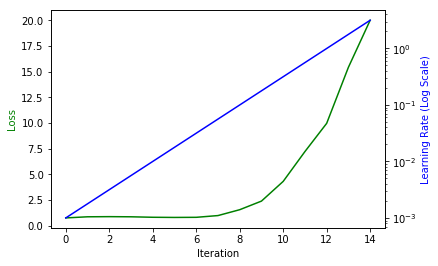

In [13]:
lr_find(sess, data['train'])

In [14]:
sess.set_lr(1e-3)

In [15]:
sess.train(schedule, 3)

Training Loss: 0.780305  Validaton Loss: 0.755017 Validation Accuracy: 0.477124


Training Loss: 0.747878  Validaton Loss: 0.703207 Validation Accuracy: 0.542484


Training Loss: 0.724114  Validaton Loss: 0.650664 Validation Accuracy: 0.640523



In [16]:
sess.unfreeze()
sess.train(schedule, 3)

Training Loss: 0.650209  Validaton Loss: 0.591976 Validation Accuracy: 0.705882


Training Loss: 0.623052  Validaton Loss: 0.548423 Validation Accuracy: 0.797386


Training Loss: 0.600906  Validaton Loss: 0.496645 Validation Accuracy: 0.823529



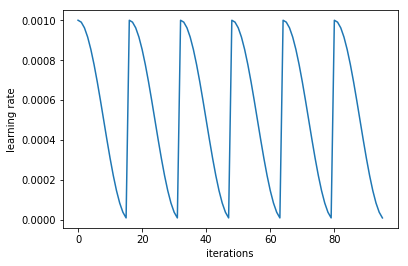

In [17]:
lr_scheduler.plot()